In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p /content/data

In [4]:
!cp /content/drive/MyDrive/PyTorch/hand/archive.zip /content/data/data.zip

In [5]:
!unzip -q /content/data/data.zip -d /content/data/

In [7]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 12.3MB/s 


In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
from PIL import Image
import random
from matplotlib import image
import shutil
from sklearn.model_selection import train_test_split
import cv2
from facenet_pytorch import MTCNN
from IPython import display
from sklearn.metrics import accuracy_score

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [10]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.CenterCrop(240), tt.Resize(64), tt.ToTensor()])
for folder in os.listdir('/content/data/leapGestRecog'):
    images = ImageFolder(os.path.join('/content/data/leapGestRecog', folder), transforms)

In [11]:
images

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/data/leapGestRecog/08
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(240, 240))
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [12]:
X_train, X_test = train_test_split(images, test_size = 0.3, random_state = 42)

In [13]:
train_data_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_data_loader = DataLoader(X_test, batch_size=16)

torch.Size([1, 64, 64])


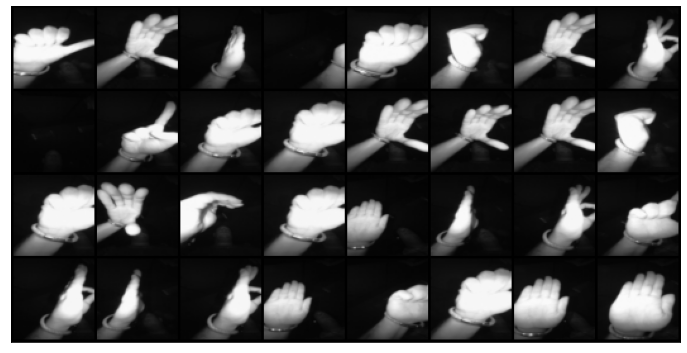

In [14]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

showbatch(train_data_loader)

In [15]:
class Hand_Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(1, 32, pool=False)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.drop = nn.Dropout(0.3)
        self.dense = nn.Sequential(nn.Flatten(), 
                                   nn.Linear(64*6*6, 256), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(256, 10), 
                                   nn.Softmax(dim=1)
                                  )
        
    @staticmethod
    def conv_block(in_feat, out_feat, pool=False):
        layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3), nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=3))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.drop(out)
        out = self.conv3(out)
        out = self.drop(out)
        out = self.dense(out)
        
        return out

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [17]:
def accuracy(pred, true):
    pred = np.argmax(pred.to('cpu').detach().numpy(), axis=1)
    true = true.to('cpu').detach().numpy()
    return len(np.where(pred==true)[0])/len(true)

In [18]:
hс = Hand_Classifier()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(hс.parameters(), lr=0.001, weight_decay=1e-6)

In [20]:
hс.to(device)

Hand_Classifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [21]:
train_loss_history = []
accuracy_history = []

for epoch in range(40):
    epoch_accuracy = []
    epoch_loss = []
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = hс(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy(outputs, labels))
    
    train_loss_history.append(np.mean(epoch_loss))
    accuracy_history.append(np.mean(epoch_accuracy))
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}, accuracy: {np.mean(epoch_accuracy)}')

Epoch 1, loss: 2.3646218180656433, accuracy: 0.09682765151515152
Epoch 2, loss: 2.3617190664464776, accuracy: 0.09943181818181818
Epoch 3, loss: 2.362192549488761, accuracy: 0.09895833333333334
Epoch 4, loss: 2.3629027767614885, accuracy: 0.09824810606060606
Epoch 5, loss: 2.3619558052583174, accuracy: 0.09919507575757575
Epoch 6, loss: 2.362192549488761, accuracy: 0.09895833333333334
Epoch 7, loss: 2.362429293719205, accuracy: 0.09872159090909091
Epoch 8, loss: 2.3629027767614885, accuracy: 0.09824810606060606
Epoch 9, loss: 2.362192549488761, accuracy: 0.09895833333333334
Epoch 10, loss: 2.362666032531045, accuracy: 0.09848484848484848
Epoch 11, loss: 2.362666032531045, accuracy: 0.09848484848484848
Epoch 12, loss: 2.3629027767614885, accuracy: 0.09824810606060606
Epoch 13, loss: 2.362192549488761, accuracy: 0.09895833333333334
Epoch 14, loss: 2.3629027713428843, accuracy: 0.09824810606060606
Epoch 15, loss: 2.362666005438024, accuracy: 0.09848484848484848
Epoch 16, loss: 2.340818296

In [22]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

mtcnn = MTCNN()

def _draw(frame, boxes):
    try:
        for box in boxes:
            # Рисуем обрамляющий прямоугольник лица на кадре
            cv2.rectangle(frame,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 0, 255),
                          thickness=2)
    except:
        print('Something wrong im draw function!')
    return frame

def digit_to_classname(digit):
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

def crop_faces(frame, boxes):
    faces = []
    for i, box in enumerate(boxes):
        faces.append(frame[int(box[1]):int(box[3]), 
            int(box[0]):int(box[2])])
    return faces
    
flag_face = "Face not detected"

while True:
    cap = cv2.VideoCapture(0) 
    ret, frame = cap.read() 
    
    boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    
    if np.all(boxes):
        # Рисуем на кадре
        frame = _draw(frame, boxes)
        flag_face = "Face detected"
    else:
        flag_face = 'Face not detected' 
        
    if flag_face == "Face detected":
    
        cv2.rectangle(frame, (0,0), (250, 250), (0, 0, 255), thickness=2)
        hand = crop_faces(frame, [[0,0, 250, 250]])[0]

        hand = cv2.resize(hand, (64, 64))
        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)    
        
        #th, dframe = cv2.threshold(hand, 0, 255)
        
        torch_hand = torch.from_numpy(hand).unsqueeze(0).to(device).float()
        #torch_hand = torch.from_numpy(dframe).unsqueeze(0).to(device).float()
        gesture_probs = hс(torch_hand[None, ...])
    
    
    cv2.imshow('Face Detection', frame) 
    
    display.clear_output(wait=False)    
    print(flag_face)    
    if flag_face == "Face detected":
        print(digit_to_classname(gesture_probs.argmax()))
        plt.imshow(torch.tensor(torch_hand.detach().cpu().numpy()[0,:,:]))    
    display.display(plt.gcf())
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Очищаем все объекты opencv, что мы создали
self.cap.release()
cv2.destroyAllWindows()

AttributeError: ignored

In [24]:
cap = cv2.VideoCapture(0) 
ret, frame = cap.read() 

#th, dframe = cv2.threshold(dframe, 30, 255, cv2.THRESH_BINARY)

cv2.rectangle(frame, (0,0), (250, 250), (0, 0, 255), thickness=2)
hand = crop_faces(frame, [[0,0, 250, 250]])[0]

hand = cv2.resize(hand, (64, 64))
hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)  
th, dframe = cv2.threshold(hand, 30, 255, cv2.THRESH_BINARY)

torch_hand = torch.from_numpy(dframe).unsqueeze(0).to(device).float()
gesture_probs = hс(torch_hand[None, ...])



plt.imshow(torch.tensor(torch_hand.detach().cpu().numpy()[0,:,:]))
plt.show()

TypeError: ignored

In [23]:
cap.release()
cv2.destroyAllWindows()























